### GDP and Gov Exp: Regression Analysis

Author: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>
Date created: November 25, 2020


Citations: <br>

   - GDP data (nominal value, national currency): 
    https://data.imf.org/?sk=4c514d48-b6ba-49ed-8ab9-52b0c1a0179b&sId=1409151240976
   
   - GDP components data (nominal value, current prices, non-seasonally adjusted, national currency)
   https://data.imf.org/regular.aspx?key=61545852

#### Step 1: Import packages

In [1]:
# standard
import pandas as pd
import numpy as np
import os

# matching
import fuzzymatcher

# plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# analysis
import patsy
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing as sklp
#from yellowbrick.regressor import ResidualsPlot

# image
from PIL import Image

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### Step 2: Define working directories

In [2]:
# in dirs
in_dir = '/Users/cilin/Dropbox/GPL_CDC_covid/data/reg/gdp/w_2020_data/'

# out dirs
out_dir = '/Users/cilin/Dropbox/GPL_CDC_covid/results/reg/gdp/'

#### Step 3: Define functions

``read data``

In [3]:
def read_data():
    '''
    '''
    return pd.read_csv(in_dir + 'gdp_reg_data.csv')

``regression analysis``

In [4]:
def concat_params(df):
    '''Concatenate parameter results across the models considered
    '''
    models = ['policy only (policy sample)', 
              'policy, cases and mobility (mobility sample)']

    results_df = pd.DataFrame()
    
    for model in models:
        if model=='policy only (policy sample)':
            # run a model only with policy controls (df cleaned based on policy data)
            temp_df = df
            print('Policy sample countries:', temp_df.country.nunique())
            print('Policy sample total obs:', temp_df.shape[0])
            # fit the model
            temp_results = model_fit(temp_df, vars_type='policy')
            temp_results['model'] = model
            # append to results_df
            results_df = pd.concat([results_df, temp_results], axis=0)
            continue

        if model=='policy, cases and mobility (mobility sample)':
            # run a model with policy and mobility controls (df cleaned based on mobility data)
            temp_df = df[df.no_mob_data==0]
            print('Mobility sample countries:', temp_df.country.nunique())
            print('Mobility sample total obs:', temp_df.shape[0])
            # fit the model
            temp_results = model_fit(temp_df, vars_type='policy, cases and mobility')
            temp_results['model'] = model
            # append to results_df
            results_df = pd.concat([results_df, temp_results], axis=0)
    
    # clean results #
    #################
    # sort by var_name
    results_df.sort_values(by=['var_name'], ascending=False, inplace=True)
    # shorten the name
    results_df['var_name'] = np.where(results_df.var_name.str.startswith('p_'), 
                                     results_df.var_name.str[:-10], results_df.var_name)
    results_df.reset_index(drop=True, inplace=True)
    

    # rearange params based on Jeanette's order
    policies = ('p_acadclose_sch_mand_on', 
                'p_acadclose_uni_mand_on',
                'p_massgath_lt10_mand_on',
                'p_massgath_gt10_mand_on',
                'p_moverest_curf_mand_on', 
                'p_moverest_stayh_mand_on', 
                'p_moverest_stayh_mand_off',
                'p_moverest_trnsp_mand_on',
                'p_offclose_ent_mand_on', 
                'p_offclose_neb_mand_on', 
                'p_passscrn_entry_mand_on',
                'p_ppe_mask_mand_on', 
                'p_reliclos_powp_mand_on',
                'p_travrest_grp_mand_on')
    
    temp = pd.DataFrame(policies, columns=['var_name'])
    temp.reset_index(drop=False, inplace=True)
    results_df = results_df.merge(temp, on='var_name', how='left')
    results_df.sort_values(by='index', inplace=True)
    results_df.drop(columns='index', inplace=True)
    results_df.reset_index(drop=True, inplace=True)
        
    return results_df

In [5]:
def model_fit(df, vars_type):
    '''Fit linear regression model
    params:
    -------
    df: merged data in wide form at the year_quarter level
    vars_type: str, indicate the 'on', 'off' type of vars to be included
    
    return:
    -------
    model params and SE
    '''
    df.reset_index(drop=True, inplace=True)
    
    # build the Y, X np.arrays
    Y, X = model_vars(df, vars_type)

    # fit the model
    model = sm.OLS(Y, X).fit(cov_type ='cluster', cov_kwds={'groups':df['country']}) 
    #print(model.summary())
    
    # get params
    params = pd.DataFrame(model.params)
    params = model_params_cleaning(params)
    
    # get ci
    ci = pd.DataFrame(model.conf_int())
    ci = model_ci_cleaning(ci)
    
    # get params with error bars
    param_errors = model_error_bar(params, ci)

    return param_errors

In [6]:
def model_vars(df, vars_type):
    '''
    '''
    df.reset_index(drop=True, inplace=True)
    
    # create FE and interactions between FE and continous vars
    f = 'l_GDP_2020USD ~ iso2 + quarter + year_trend * C(iso2_quarter)'
    Y, X_fe = patsy.dmatrices(f, df, return_type='dataframe')
    
    # create policies
    policies = ('p_acadclose_sch_mand_on', 
                'p_acadclose_uni_mand_on',
                'p_massgath_lt10_mand_on',
                'p_massgath_gt10_mand_on',
                'p_moverest_curf_mand_on', 
                'p_moverest_stayh_mand_on', 
                'p_moverest_stayh_mand_off',
                'p_moverest_trnsp_mand_on',
                'p_offclose_ent_mand_on', 
                'p_offclose_neb_mand_on', 
                'p_passscrn_entry_mand_on',
                'p_ppe_mask_mand_on', 
                'p_reliclos_powp_mand_on',
                'p_travrest_grp_mand_on')
        

    on_off_policies = list(np.sort([col for col in df.columns if col.startswith(policies)]))
    cases = ['new_cases_per100k']
    mobility = ['mob_residential']
    
    if vars_type == 'policy':
        X_vars =  on_off_policies
        X = pd.concat([df[X_vars], X_fe], axis=1)
        
    if vars_type == "policy, cases and mobility":
        X_vars = on_off_policies + cases + mobility
        X = pd.concat([df[X_vars], X_fe], axis=1)
    
    return Y, X

In [7]:
def model_params_cleaning(df):
    """ Clean param df
    # param df: df
    # return param df in clean form
    """
    # add index as column
    df.reset_index(inplace=True)
    
    # rename columns
    df.rename(columns = {'index': 'var_name', 0: 'coef'}, inplace=True)
    
    # keep only the policy vars
    df['var_name'] = df.var_name.astype(str)
    df = df[df.var_name.str.startswith(('p_', 'new', 'mob'))]
    
    return df

In [8]:
def model_ci_cleaning(df):
    """ Clean ci df
    # param df: df
    # return ci df in clean form
    """
    # add index as column
    df.reset_index(inplace=True)
    
    # rename columns
    df.rename(columns = {'index': 'var_name', 0: 'ci_0', 1: 'ci_1'}, inplace=True)
    
    # keep only the policy vars
    df['var_name'] = df.var_name.astype(str)
    df = df[df.var_name.str.startswith(('p_', 'new', 'mob'))]
    
    return df

In [9]:
def model_error_bar(df1, df2):
    """ Calculate the error bar lenghts for ci
    # param df1: params df
    # param df2: ci df
    # return params df with added error bar
    """
    error_bar = pd.DataFrame(df1.loc[:,'coef'] - df2.loc[:,'ci_1'])
    error_bar.rename(columns = {0: 'ci_0'}, inplace=True)
    
    # add params and error_bar to a df
    df = pd.concat((df1.loc[:, ['var_name', 'coef']], error_bar), axis=1)
    
    return df

``plots``

In [10]:
def plots_gdp_components(df):
    '''Plot summary stats of l_GDP 
    params:
    -------
    df with merged data
    
    return:
    -------
    matplotlib graph
    '''
    
    # sort data by year
    df.sort_values(by =['iso2', 'year', 'quarter'], inplace=True)
    
    # define x_date labels and countries of interest
    countries = [val for val in df.country.unique()];

    ### initialize a new plot
    plt.figure(figsize=(30, 200))

    for i in range(0, len(countries)): # change here for how many countries to plot
        # initialize new plot
        plt.subplot(len(countries), 2, i+1)

        # subset data by country
        temp_df = df[df.country==countries[i]]

        # create x_labels for each country
        x_labels = [val for val in temp_df.year_quarter.unique()]
        x_labels.sort()

        # plot time-series #
        ####################
        plt.plot(temp_df.year_quarter, temp_df.l_GDP_2020USD, label='l_GDP_2020USD')

        # add vertical line for 2020Q1 and 2020Q2
        #plt.axvline(x='2020Q1', color='gray', label='2020Q1')
        #plt.axvline(x='2020Q2', color='green', label='2020Q2')

        # set legend, title, axis #
        ###########################
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
        plt.title(countries[i])
        #plt.xticks(x_labels[::3])
        plt.xticks(x_labels)
        #plt.ylim(6, 16)

    # save figure
    #plt.savefig(out_dir_plots + 'gdp_debt_plots.pdf', bbox_inches = 'tight')  

In [11]:
def coef_plots(coef_df):
    '''Plot coefficient estimates and SE
    params:
    ------
    coef_df: df, contains coef estimates and CI

    return:
    -------
    None; saves .png file
    '''
    ## markers/labels to use
    marker_list = ['d']
    line_color = ['orangered', 'darkgreen']*(df_params.var_name.nunique()-2) + ['orangered', 'orangered']
    #x_labels = coef_df.var_name
    x_labels = []
    for idx, value in enumerate(df_params.var_name):
        if idx%2 == 0:
            x_labels.append(value)
        else:
            x_labels.append(' ')
    x_labels[len(x_labels)-1] = 'residential_mobility'

    ## define x base 
    width = 0.20
    base_x = pd.np.arange(len(x_labels)) 

    # plot graphs
    fig, ax = plt.subplots(figsize=(8, 4))


    # keep coef values for one model at a time
    model_df = coef_df
    model_df = model_df.set_index('var_name')

    # plot bars
    X = base_x + width*2
    ax.bar(X, model_df['coef'], yerr=model_df['ci_0'], color = 'none', ecolor=line_color, width=0.4, 
           orientation='vertical', error_kw=dict(elinewidth=1))

    # plot markers
    ax.scatter(x=X,  marker=marker_list[0], s=20, 
                y=model_df['coef'], color=line_color)


    # add vertical and horizontal lines
    ax.axhline(y=0, linewidth=1, color='orangered')
    ax.axvline(x=-0.1, linewidth=0.5, color='grey')
    for val in np.arange(1.8, 30, 2.0):
        ax.axvline(x=val, linewidth=0.5, color='grey')
    #ax.axvline(x=31, linewidth=0.5, color='grey')
    #ax.axvline(x=32, linewidth=0.5, color='grey')

    
    # add title, labels, legend 
    ax.xaxis.set_ticks_position('none')
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=90, fontsize=12, color='white')
    #ax.set_ylim(-0.8, 0.8)
    #ax.set_ylim(-1.2, 1.2)
    ax.set_ylim(-0.5, 0.5)
    ax.yaxis.set_ticks_position("right")
    plt.yticks(rotation=90, color='white');

 
    # plot title
    ax.set_ylabel('Outcome var: ' + 'l_GDP_2020USD' + '\n FE: iso2, quarter, iso2_quarter, timetrend*iso2_quarter',
                  fontsize=14, color='white')
        
    # save figure
    plt.savefig(out_dir + 'reg_gdp_coef.png', bbox_inches = 'tight') 
    
    # supress output
    plt.close()

In [12]:
def residual_plots(df, vars_type, outcome):
    ''' Plot model residuals
    params:
    -------
    vars_type: str, type of controls to be include, e.g., on_and_grp policies
    outcome: str, GDP, HHE, GOVE
    
    return:
    -------
    none
    '''
    fig, ax = plt.subplots(figsize=(7.64, 3))
    
    Y, X = model_vars(df, vars_type, outcome)
    model = LinearRegression(fit_intercept=True)
    viz = ResidualsPlot(model, hist=False, qqplot=True)
    viz.fit(X, Y)
    viz.show()

---
#### Step 4: Read data
---

In [13]:
df = read_data()
df.head(2)

,Unnamed: 0,who_region,country,iso2,year_quarter,nat_pop,new_cases_imputed,mob_residential,who_region_y,GDP,...,p_travquar_rec_mand_off_popwt_qwt,p_travrest_airprt_mand_off_popwt_qwt,p_travrest_airprt_rec_mand_off_popwt_qwt,p_travrest_flght_mand_off_popwt_qwt,p_travrest_flght_rec_mand_off_popwt_qwt,p_travrest_tradv_mand_off_popwt_qwt,p_travrest_tradv_rec_mand_off_popwt_qwt,p_travrest_trban_mand_off_popwt_qwt,p_travrest_trban_rec_mand_off_popwt_qwt,p_travrest_grp_mand_on_popwt_qwt
0,0,EURO,Albania,AL,2014Q1,0.0,0.0,0.0,EURO,315138.273418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,EURO,Albania,AL,2014Q2,0.0,0.0,0.0,EURO,370523.883299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df.shape

(1404, 94)

---
#### Step 5: Plot data
---

In [15]:
#plots_gdp_components(df)

---
#### Step 6: Regression analysis
---

Policy sample countries: 54
Policy sample total obs: 1404
Mobility sample countries: 48
Mobility sample total obs: 1248


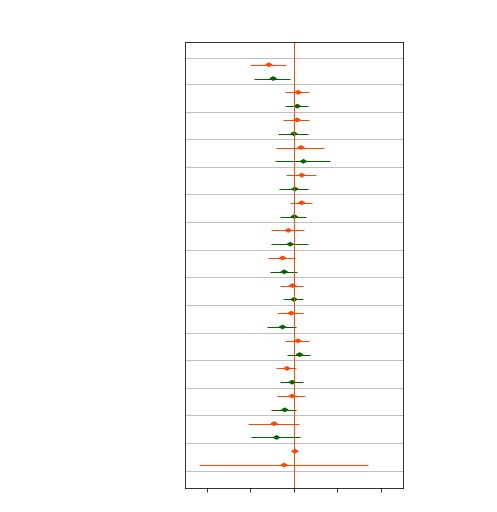

In [16]:
# get params
df_params = concat_params(df)

# plot params
coef_plots(df_params)
Image.open(out_dir + 'reg_gdp_coef.png').rotate(270, expand=True)